The database is composed by several CSV (Comma-Separated Values) files, each one with 8 columns, one column for each sensor, according to:

column 1 tachometer signal that allows to estimate rotation frequency;

columns 2 to 4 underhang bearing accelerometer (axial, radiale tangential direction);

columns 5 to 7 overhang bearing accelerometer (axial, radiale tangential direction);

column 8 microphone.

source: https://www02.smt.ufrj.br/~offshore/mfs/page_01.html

Nesse projeto eliminamos as colunas 1,2,3,7 de cada arquivo csv. Restaram as leituras do tacômetro e do acelerômetro triaxial em 4, 5 e 6 (ax, rd and tan):

0 - Tachometer. 1 - Axial direct. 2 - radial direct. 3 - tangential direct.

According to the description of the columns there are not one two radial orthogonal accelerometers. Thus, it is not possible to observe the movement orbit of the rotating machine.

On the other hand, perhaps the tangential accelerometer is also moving radially, therefore orthogonal to the radial accelerometer.

Soft-DTW é uma função de perda diferenciável usada em análise de séries temporais, baseada no Dynamic Time Warping (DTW). Permite comparar séries de tamanhos variáveis, é robusta a deslocamentos e dilatações no tempo, e pode ser usada em aprendizado de máquina para tarefas como média, clustering e previsão.


In [ ]:
pip install soft-dtw

In [1]:
pip show soft-dtw

Name: soft-dtw
Version: 0.1.6
Summary: Python implementation of soft-DTW
Home-page: https://github.com/mblondel/soft-dtw/
Author: 
Author-email: 
License: Simplified BSD
Location: d:\Jupyter\Math\math\Lib\site-packages
Requires: chainer, cython, numpy, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install filterpy

In [2]:
pip show filterpy

Name: filterpy
Version: 1.4.5
Summary: Kalman filtering and optimal estimation library
Home-page: https://github.com/rlabbe/filterpy
Author: Roger Labbe
Author-email: rlabbejr@gmail.com
License: MIT
Location: d:\Jupyter\Math\math\Lib\site-packages
Requires: matplotlib, numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from filterpy.kalman import KalmanFilter

sns.set(style='whitegrid')



### Normal

In [ ]:
# df_20g = ('/kaggle/input/mafaulda-bas/mafaulda_bas/overhang/ball_fault/20g')

# df_normal = ('/kaggle/input/mafaulda-bas/mafaulda_bas/normal')

# df_caminho_desbalanceado = ('/kaggle/input/mafaulda-bas/mafaulda_bas/imbalance/25g')

### 1 - Leitura do Dset:

In [4]:
def carregar_dados_mafaulda(pasta, label):
    arquivos = [f for f in os.listdir(pasta) if f.endswith('.csv')]
    dados = []
    for arq in arquivos:
        try:
            df = pd.read_csv(os.path.join(pasta, arq), header=None, skiprows=1)
            df['label'] = label
            dados.append(df)
        except Exception as e:
            print(f"Erro ao ler {arq}: {e}")
    return pd.concat(dados, ignore_index=True) if dados else None


In [7]:
# Ajuste os caminhos conforme o seu ambiente:
path_normal = r"C:\Files\mafaulda_bas\normal_small"
path_20g = r"C:\Files\mafaulda_bas\imbal_small\20g"

df_normal = carregar_dados_mafaulda(path_normal, label=0)
df_20g = carregar_dados_mafaulda(path_20g, label=1)

# Verifica se as classes têm amostras suficientes
if df_normal is None or df_20g is None or len(df_normal) < 2 or len(df_20g) < 2:
    raise ValueError("As duas classes precisam ter ao menos 2 amostras para classificação.")


In [8]:
# Concatenar
df = pd.concat([df_normal, df_20g], ignore_index=True)

In [9]:
# Vamos usar apenas a coluna de índice 5 (acelerômetro radial superior)
X = df.iloc[:, 3].values.reshape(-1, 1)  # Coluna 3 (índice 3) como feature, vibração radial superior
y = df['label'].values                   # Coluna criada de rótulo

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Conferir contagem de cada classe antes de dividir
classes, counts = np.unique(y, return_counts=True)
print("Distribuição de classes:", dict(zip(classes, counts)))

Distribuição de classes: {np.int64(0): np.int64(12249951), np.int64(1): np.int64(12249951)}


#### 2 - Pré-processamento:

In [11]:
# Normalização
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Garantir que todas as classes têm pelo menos 2 amostras
if np.min(counts) < 2:
    raise ValueError("Alguma classe tem menos de 2 amostras. Não é possível fazer stratified split.")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
# Treinamento e Validação:

clf = RandomForestClassifier(n_estimators=5, random_state=42)
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Acurácia SEM Kalman: 0.7242
              precision    recall  f1-score   support

           0       0.68      0.84      0.75   2449991
           1       0.79      0.61      0.69   2449990

    accuracy                           0.72   4899981
   macro avg       0.74      0.72      0.72   4899981
weighted avg       0.74      0.72      0.72   4899981



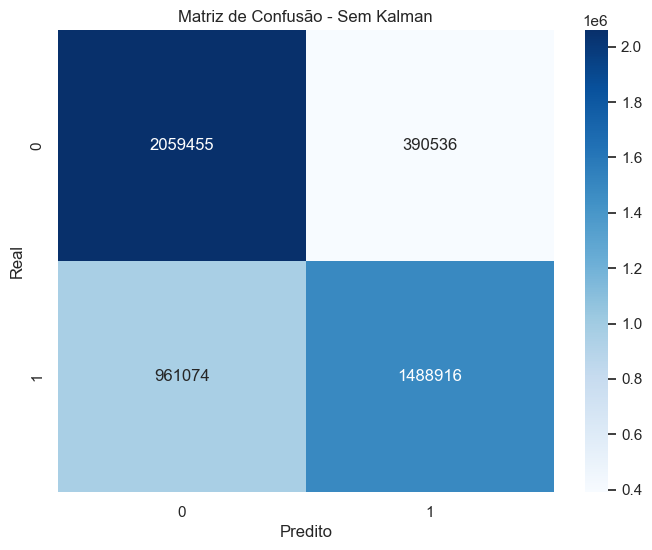

In [13]:
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia SEM Kalman: {acc:.4f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Sem Kalman")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


- Aplicar o filtro Kalman na coluna 5:

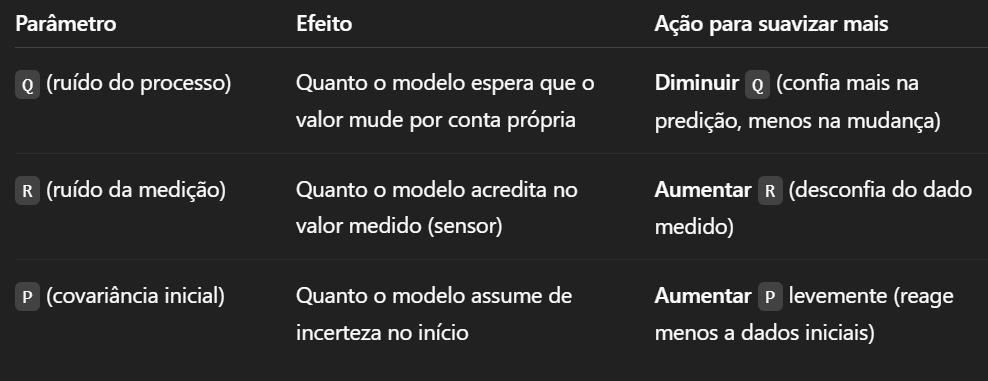

In [14]:
def aplicar_kalman_coluna(X):
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([[X[0]]])
    kf.F = np.array([[1.]])
    kf.H = np.array([[1.]])
    kf.P *= 50
    kf.R = 1.2
    kf.Q = 1e-5
    filtrado = []
    for z in X:
        kf.predict()
        kf.update([z])
        filtrado.append(kf.x[0][0])
    return np.array(filtrado)


In [16]:
# 1. Seleciona a coluna do acelerômetro (coluna 5)
col_raw = df.iloc[:, 3].values.reshape(-1, 1)  # Coluna 5 (índice 5) como feature
# y = df['label'].values                   # Coluna criada de rótulo

# 2. Aplica o filtro de Kalman sobre essa coluna
col_filtrada = aplicar_kalman_coluna(col_raw).reshape(-1, 1)

# 3. Normaliza a coluna filtrada
scaler = StandardScaler()
X = scaler.fit_transform(col_filtrada)

# 4. Define os rótulos
y = df['label'].values

In [17]:

# Conferir contagem de cada classe antes de dividir
classes, counts = np.unique(y, return_counts=True)
print("Distribuição de classes:", dict(zip(classes, counts)))

Distribuição de classes: {np.int64(0): np.int64(12249951), np.int64(1): np.int64(12249951)}


In [18]:
# Normalização
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Garantir que todas as classes têm pelo menos 2 amostras
if np.min(counts) < 2:
    raise ValueError("Alguma classe tem menos de 2 amostras. Não é possível fazer stratified split.")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [19]:
# Treinamento e Validação:

clf = RandomForestClassifier(n_estimators=5, random_state=42)
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia SEM Kalman: {acc:.4f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Com Kalman")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

KeyboardInterrupt: 

aqui parou

In [ ]:
# Lista para armazenar os DataFrames
dataframes = []

# Verifica se o caminho fornecido é um diretório válido
if os.path.isdir(df_normal):
    # Iterar pelos arquivos no diretório
    for filename in os.listdir(df_normal):
        # AQUI ESTÁ A CORREÇÃO: use 'endswith' em vez de 'endswitch'
        if filename.endswith(".csv"): 
            file_path = os.path.join(df_normal, filename)
            
            try:
                # Lendo o arquivo CSV, pulando a primeira linha (cabeçalho).
                # O parâmetro skiprows=1 é a chave para resolver o problema do 'object' dtype.
                df = pd.read_csv(file_path, sep=',', header=None, skiprows=1)
                dataframes.append(df)
            except Exception as e:
                print(f"Não foi possível ler o arquivo {filename}: {e}")


    if dataframes:
        #Concatenando os dataframes em um único:
        df_normal_concat = pd.concat(dataframes, ignore_index=True)

        # Mostrando as primeiras linhas e tipos de dados:
        print("__Dataframe combinado (df_20g_concat) ___")
        print(df_normal_concat.head())
        print("\n--- Tipos de dados (dtypes) ---")
        print(df_normal_concat.dtypes)
    else:
        print("Não houve leitura de arquivos")
else:
    print(f"diretório df_20g não encontrado: {df_normal}")


"""# Iterar pelos arquivos no diretório
for filename in os.listdir(df_20g):
    file_path = os.path.join(df_20g, filename)  # Caminho completo do arquivo
    df = pd.read_csv(file_path, sep=',', header=None)  # Lendo o arquivo CSV
    dataframes.append(df)  # Adicionando o DataFrame à lista dataframes

# Concatenando todos os DataFrames em um único DataFrame
df_20g_conc = pd.concat(dataframes, ignore_index=True)

# Mostrando as primeiras linhas do DataFrame combinado
print(df_20g_conc.head()) """

In [ ]:
"""def load_data(dir_10g):
    # Lista para armazenar os DataFrames
    dataframes = []

    # Iterar pelos arquivos no diretório
    for filename in os.listdir(dir_10g):
        file_path = os.path.join(dir_10g, filename)  # Caminho completo do arquivo
        df = pd.read_csv(file_path, sep=',', header=None)  # Lendo o arquivo CSV
        dataframes.append(df)  # Adicionando o DataFrame à lista

    # Concatenar todos os DataFrames em um único DataFrame
    all_data = pd.concat(dataframes, ignore_index=True)

    # Supondo que a última coluna seja a de rótulos (y) e o resto são features (X)
    X = all_data.iloc[:, :-1]  # Todas as colunas, exceto a última, são as features
    y = all_data.iloc[:, -1]   # A última coluna é o rótulo (classe)
    
    return X, y"""




- Supondo ultima coluna como rotulos ou classes (y) e as demais como features (X):

In [ ]:
X = df_20g_concat.iloc[:, :-1]   # Seleciona todas as linhas ':' e exclui a última coluna ':-1'
y = df_20g_concat.iloc[:, -1]    # Seleciona todas as linhas ':' e a última coluna ':-1'

In [ ]:
print("X df_normal_20g:\n", X.head(), "\nX dtypes:\n", X.dtypes)

In [ ]:
print("y df_normal_20g:\n", y.head(), "\n y dtypes:\n", y.dtypes)

- É um comportamento esperado do pandas. Essa linha não se refere a uma coluna específica do seu DataFrame. Ela descreve o tipo de dados da própria lista de tipos que está sendo exibida. Como a lista contém vários objetos de tipo float64 e outros, o pandas a classifica como uma série de tipo object.
- fit (Ajustar/Aprender): A primeira parte, fit, "olha" para cada coluna (cada sensor), calcula a média (μ) e o desvio padrão (σ) daquela coluna específica, aprendendo os parâmetros de distribuição dos dados.

In [ ]:
# Função para normalizar os dados. preprocess_data padroniza os dados antes de entregá-los ao modelo para tr
def preprocess_data(X):              # X  é o conjunto de dados de entrada (as leituras dos 8 sensores de vibração
    scaler = StandardScaler()        # classe da bibl. scikit-learn para padronização. Transforma os dados para média=0 e d_p =1.
    X_scaled_out = scaler.fit_transform(X)
    return X_scaled_out

- Para que este código seja executável de forma independente, vamos criar um 'X' de exemplo.
- Caso não exista podemos ignorar ou remover este bloco 'if'.

### Tacômetro

In [ ]:
print("\n1. Aplicando a normalização (StandardScaler) aos dados de X...")
X_scaled = preprocess_data(X)
print("   'X_scaled' foi criado com sucesso!")
print(f"   Formato do X_scaled: {X_scaled.shape}, Tipo: {type(X_scaled)}")
print('-----------------------------------------')
# VISUALIZAR OS DADOS NORMALIZADOS
print("\n2. Gerando gráficos para visualização...")

sensor_a_visualizar = 0 
raw_tac_signal = X.iloc[:, sensor_a_visualizar].values
scaled_tac_signal = X_scaled[:, sensor_a_visualizar]

# --- Gráfico 1: Comparação do Sinal no Tempo ---
plt.figure(figsize=(16, 8))

# Gráfico do sinal original
plt.subplot(2, 1, 1)
plt.plot(raw_tac_signal, label=f'Sinal Original Tacômetro (Sensor {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Tacômetro {sensor_a_visualizar}', fontsize=10)
plt.ylabel('Amplitude Original do Tacômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# Gráfico do sinal normalizado
plt.subplot(2, 1, 2)
plt.plot(scaled_tac_signal, label=f'Sinal Normalizado (Tacômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Tacômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel('Amostra no Tempo', fontsize=10)
plt.ylabel('Amplitude Normalizada do Tacômetro', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
# --- Gráfico 2: Comparação da Distribuição dos Dados (Histograma) ---
plt.figure(figsize=(16, 6))

# Histograma do sinal original
plt.subplot(1, 2, 1)
sns.histplot(raw_tac_signal, kde=True, color='blue', bins=50)
plt.title(f'Distribuição Original do Tacômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem)', fontsize=10)
plt.ylabel('Amplitude original (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

# Histograma do sinal normalizado
plt.subplot(1, 2, 2)
sns.histplot(scaled_tac_signal, kde=True, color='red', bins=50)
plt.title(f'Distribuição Normalizada do Tacômetro (Sensor {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Tempo (amostragem) Normalizado', fontsize=10)
plt.ylabel('Amplitude normalizada (1x106)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

print("\nVisualização concluída.")

In [ ]:
# 2. VISUALIZAR OS DADOS NORMALIZADOS (COM ZOOM)
print("\n2. Gerando gráficos para visualização...")

# Escolha qual coluna do sensor (0 a 7) você quer visualizar
sensor_a_visualizar = 0 
# Define o número de amostras para o "zoom" para melhor visualização
# num_amostras_plot = 1500
num_amostras_plot = 5000

# Pega todos os dados da coluna do sensor escolhido
raw_tac_signal = X.iloc[:, sensor_a_visualizar].values
scaled_tac_signal = X_scaled[:, sensor_a_visualizar]

# --- Gráfico 1: Comparação do Sinal no Tempo (com zoom) ---
plt.figure(figsize=(16, 8))

# Gráfico do sinal original (zoom)
plt.subplot(2, 1, 1)
# Plota apenas as primeiras 'num_amostras_plot' amostras para dilatar o eixo X
plt.plot(raw_tac_signal[:num_amostras_plot], label=f'Sinal Original (Tacômetro {sensor_a_visualizar})', color='blue', alpha=0.4)
plt.title(f'Sinal Original do Tacômetror {sensor_a_visualizar} (Zoom nas primeiras {num_amostras_plot} amostras)', fontsize=10)
plt.ylabel('Amplitude Original (1x106)', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico do sinal normalizado (zoom)
plt.subplot(2, 1, 2)
# Plota apenas as primeiras 'num_amostras_plot' amostras
plt.plot(scaled_tac_signal[:num_amostras_plot], label=f'Sinal Normalizado (Tacômetro {sensor_a_visualizar})', color='red', alpha=0.4)
plt.title(f'Sinal Normalizado do Tacômetro {sensor_a_visualizar} (Média ≈ 0, Desvio Padrão = 1)', fontsize=10)
plt.xlabel(f'Amostras (0 a {num_amostras_plot})', fontsize=10)
plt.ylabel('Amplitude Normalizada (1x106)', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- Gráfico 2: Comparação da Distribuição dos Dados (usando o sinal completo) ---
plt.figure(figsize=(16, 6))

# Histograma do sinal original
plt.subplot(1, 2, 1)
sns.histplot(raw_tac_signal, kde=True, color='blue', bins=50)
plt.title(f'Distribuição do Sinal Original (Tacômetro {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Amplitude', fontsize=10)
plt.ylabel('Contagem', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Histograma do sinal normalizado
plt.subplot(1, 2, 2)
sns.histplot(scaled_tac_signal, kde=True, color='red', bins=50)
plt.title(f'Distribuição do Sinal Normalizado (Tacômetro {sensor_a_visualizar})', fontsize=10)
plt.xlabel('Amplitude Normalizada (1x106)', fontsize=10)
plt.ylabel('Contagem', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nVisualização concluída.")

- "Contagem" significa a frequência ou o número de vezes que um determinado valor de amplitude ocorreu no seu conjunto de dados.
- A linha azul contínua (chamada de KDE - Kernel Density Estimate) é uma versão suavizada do histograma. O pico dessa linha mostra qual é o valor de amplitude mais comum em todo o conjunto de dados.

### Analisando a categoria Normal

- Análise no Domínio do Tempo (Sincronização e Visualização): Primeiro, vamos plotar o sinal de vibração do acelerômetro contra uma base de tempo real em segundos e, ao mesmo tempo, usar o tacômetro para calcular a rotação exata da máquina (RPM) naquele ensaio.
- Análise no Domínio da Frequência (Objetivo): Em seguida, usaremos a Transformada Rápida de Fourier (FFT) para converter o sinal de vibração do domínio do tempo para o domínio da frequência. É aqui que a "assinatura" do desbalanceamento se tornará visível e quantificável.
- o sinal do tacômetro nos dá a base de tempo (a rotação da máquina), e o sinal do acelerômetro nos dá a vibração.
- Categoria Normal já carregada anteriormente.

In [ ]:
import os
# Lista para armazenar os DataFrames
dataframes = []

# Verifica se o caminho fornecido é um diretório válido
if os.path.isdir(df_normal):
    # Iterar pelos arquivos no diretório
    for filename in os.listdir(df_normal):
        # AQUI ESTÁ A CORREÇÃO: use 'endswith' em vez de 'endswitch'
        if filename.endswith(".csv"): 
            file_path = os.path.join(df_normal, filename)
            
            try:
                # Lendo o arquivo CSV, pulando a primeira linha (cabeçalho).
                # O parâmetro skiprows=1 é a chave para resolver o problema do 'object' dtype.
                df = pd.read_csv(file_path, sep=',', header=None, skiprows=1)
                dataframes.append(df)
            except Exception as e:
                print(f"Não foi possível ler o arquivo {filename}: {e}")


    if dataframes:
        #Concatenando os dataframes em um único:
        df_normal_concat = pd.concat(dataframes, ignore_index=True)

        # Mostrando as primeiras linhas e tipos de dados:
        print("__Dataframe combinado (df_normal_concat) ___")
        print(df_normal_concat.head())
        print("\n--- Tipos de dados (dtypes) ---")
        print(df_normal_concat.dtypes)
    else:
        print("Não houve leitura de arquivos")
else:
    print(f"diretório df_20g não encontrado: {df_normal}")


In [ ]:
COLUNA_TACOMETRO = 0
# Coluna do acelerômetro radial do overhang (sexta coluna, índice 5)
COLUNA_ACELEROMETRO = 5 

# Parâmetros do dataset MAFAULDA
TAXA_AMOSTRAGEM = 50000  # 50 kHz
DURACAO_ENSAIO_S = 5    # 5 segundos

In [ ]:
# --- FUNÇÃO PARA ANÁLISE E PLOTAGEM ---
def analisar_sinal_temporal(caminho_arquivo, nome_condicao):
    """
    Carrega, analisa e plota o sinal de vibração e calcula o RPM a partir do tacômetro.
    """
    if not os.path.exists(caminho_arquivo):
        print(f"AVISO: Arquivo não encontrado: {caminho_arquivo}")
        return None, None

    print(f"\n--- Analisando Condição: {nome_condicao} ---")
    
    # Carrega o arquivo CSV, pulando a linha de cabeçalho se houver
    df = pd.read_csv(caminho_arquivo, header=None, skiprows=1)

    # Extrai os sinais do acelerômetro e do tacômetro
    sinal_acelerometro = df.values
    sinal_tacometro = df.values


In [ ]:
# --- Cálculo do RPM a partir do Tacômetro ---
# O tacômetro gera um pulso por rotação. Contamos os pulsos.
# Um pulso é detectado quando o sinal cruza um limiar (ex: valor 2.5) para cima.
limiar_pulso = 2.5
pulsos = np.where((sinal_tacometro[:-1] < limiar_pulso) & (sinal_tacometro[1:] >= limiar_pulso))
num_pulsos = len(pulsos)
    
# Calcula RPM (Rotações por Minuto)
rpm = (num_pulsos / DURACAO_ENSAIO_S) * 60
print(f"RPM Calculado: {rpm:.2f}")


In [ ]:

# --- Plotagem do Sinal de Vibração ---
    # Cria o eixo de tempo em segundos
num_amostras = len(sinal_acelerometro)
eixo_tempo_s = np.linspace(0, DURACAO_ENSAIO_S, num_amostras)
    
    # Zoom para visualizar melhor a forma de onda (primeiras 2000 amostras)
amostras_plot = 2000

plt.figure(figsize=(15, 5))
plt.plot(eixo_tempo_s[:amostras_plot], sinal_acelerometro[:amostras_plot], label=f'Sinal do Acelerômetro (Sensor {COLUNA_ACELEROMETRO})')
plt.title(f'Sinal de Vibração no Domínio do Tempo - Condição: {nome_condicao} (RPM: {rpm:.0f})', fontsize=14)
plt.xlabel('Tempo (segundos)', fontsize=12)
plt.ylabel('Amplitude da Vibração', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
    
return sinal_acelerometro, rpm

# --- EXECUÇÃO ---
sinal_normal, rpm_normal = analisar_sinal_temporal(caminho_normal, "Normal")
sinal_desbalanceado, rpm_desbalanceado = analisar_sinal_temporal(caminho_desbalanceado, "Desbalanceamento 20g")

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

def build_model(input_shape, output_size):
    # Inicializa o modelo EfficientNetB0
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Congelar as camadas da base para transferência de aprendizado

    # Adiciona camadas personalizadas ao modelo
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Para agregar as características
        layers.Dense(64, activation='relu'),  # Camada densa com ativação ReLU
        layers.Dense(output_size, activation='softmax')  # Camada de saída com softmax para classificação
    ])
    
    return model

"""# Definições de entrada e número de classes
input_shape = (32, 32, 3)  # Dimensões de entrada
output_size = 8  # Número de classes (ajuste conforme necessário)

# Construindo o modelo
model = build_model(input_shape, output_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Resumo do modelo
model.summary()"""

In [ ]:
# Função para treinar o modelo com Soft-DTW
"""def train_model_with_soft_dtw(X_train, y_train, X_test, y_test, num_epochs=2, learning_rate=0.0001):
    input_shape = (32, 32, 3)  # Ajuste para a entrada do modelo EfficientNetB0
    output_size = len(np.unique(y_train))  # Número de classes
    
    # Convertendo dados para TensorFlow Tensors
    X_train_tensor = tf.convert_to_tensor(X_train.reshape(-1, 32, 32, 3), dtype=tf.float32)  # Redimensionar
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
    X_test_tensor = tf.convert_to_tensor(X_test.reshape(-1, 32, 32, 3), dtype=tf.float32)  # Redimensionar
    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

    # Inicializando o modelo
    model = build_model(input_shape, output_size)  #Atribuindo model a uma var.
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    # Inicializando o Soft-DTW
    soft_dtw = SoftDTW(gamma=0.1)  # Ajustar gamma conforme necessário

    history = {'loss': [], 'accuracy': [], 'error': []}  # Para armazenar as perdas e acurácia

    # Loop de treinamento
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            # Predição do modelo
            predictions = model(X_train_tensor)  # Predição
            # Cálculo da perda de entropia cruzada
            loss_ce = loss_fn(y_train_tensor, predictions)
            # Cálculo da perda Soft-DTW
            loss_dtw = soft_dtw(X_train_tensor, predictions)
            # Perda total (entropia cruzada + Soft-DTW)
            total_loss = loss_ce + loss_dtw

        # Backpropagation
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Armazenando a perda, acurácia e erro para cada época
        history['loss'].append(total_loss.numpy())
        accuracy = accuracy_score(np.argmax(predictions.numpy(), axis=1), y_train)
        history['accuracy'].append(accuracy)
        history['error'].append(1 - accuracy)  # Calculando o erro como 1 - acurácia

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.numpy()}, Accuracy: {accuracy:.2f}, Error: {1 - accuracy:.2f}')

    return history"""

In [ ]:
# Definindo variáveis necessárias
num_epochs = 2  # Número de épocas para o treinamento
learning_rate = 0.0001  # Taxa de aprendizado
input_shape = (32, 32, 3)  # Ajuste para a entrada do modelo EfficientNetB0
output_size = len(np.unique(y_train))  # Número de classes

# Convertendo dados para Tensores do TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)  # Não há reshaping necessário
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)  # Não há reshaping necessário
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Inicializando o modelo
model = build_model(input_shape, output_size)  # Atribuindo model a uma var.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Inicializando o otimizador
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()  # Função de perda

# Inicializando o Soft-DTW
D = np.zeros((len(X_train_tensor), len(X_train_tensor)))  # Defina a matriz de distância corretamente
soft_dtw = SoftDTW(gamma=0.1, D=D)  # Ajustar gamma conforme necessário

# Para armazenar as perdas e acurácia
#history = {'loss': [], 'accuracy': [], 'error': []}

# Loop de treinamento
# Loop de treinamento
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        # Predição do modelo
        predictions = model(X_train_tensor)
        # Cálculo da perda de entropia cruzada
        loss_ce = loss_fn(y_train_tensor, predictions)
        # Cálculo da perda Soft-DTW (calculando conforme necessário, não usando uma matriz D)
        loss_dtw = soft_dtw(X_train_tensor, predictions)  # Isso deve ser implementado para calcular distâncias sob demanda
        
        # Calcular a perda Soft-DTW sob demanda
        loss_dtw = sum(soft_dtw(X_train_tensor[i], predictions[i]) for i in range(len(X_train_tensor)))
        
        # Perda total
        total_loss = loss_ce + loss_dtw

    # Backpropagation
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Armazenando a perda, acurácia e erro para cada época
    history['loss'].append(total_loss.numpy())
    accuracy = accuracy_score(np.argmax(predictions.numpy(), axis=1), y_train)
    history['accuracy'].append(accuracy)
    history['error'].append(1 - accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.numpy()}, Accuracy: {accuracy:.2f}, Error: {1 - accuracy:.2f}')

In [ ]:
# Definindo variáveis necessárias
num_epochs = 2  # Número de épocas para o treinamento
learning_rate = 0.0001  # Taxa de aprendizado
input_shape = (32, 32, 3)  # Ajuste para a entrada do modelo EfficientNetB0
output_size = len(np.unique(y_train))  # Número de classes

# Verificando se os dados têm o formato adequado antes de redimensionar
if X_train.shape[1] == 32 * 32 * 3:
    X_train_tensor = tf.convert_to_tensor(X_train.reshape(-1, 32, 32, 3), dtype=tf.float32)  # Redimensionar
else:
    raise ValueError(f"X_train deve ter {32 * 32 * 3} características, mas tem {X_train.shape[1]}.")

if X_test.shape[1] == 32 * 32 * 3:
    X_test_tensor = tf.convert_to_tensor(X_test.reshape(-1, 32, 32, 3), dtype=tf.float32)  # Redimensionar
else:
    raise ValueError(f"X_test deve ter {32 * 32 * 3} características, mas tem {X_test.shape[1]}.")

# Convertendo y_train e y_test para tensores
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)


Implicações de Usar training=True
Camadas de Dropout: Se você estiver utilizando camadas de dropout no seu modelo, elas funcionarão de maneira diferente. Durante o treinamento, dropout desativa aleatoriamente uma fração das unidades (neurônios) para ajudar a prevenir overfitting. Quando training=True, algumas unidades serão desativadas, enquanto training=False garante que todas as unidades estão ativas, permitindo que o modelo faça previsões consistentes.

Normalização: Se você estiver usando camadas de normalização, como Batch Normalization, a média e a variância usadas para normalizar as entradas durante o treinamento diferem das usadas durante a inferência. Com training=True, as estatísticas da mini-batch serão usadas, enquanto training=False usará as médias e variâncias acumuladas durante o treinamento.

Logo, usar training=True geralmente é apropriado durante o processo de treinamento do modelo, mas não deve ser usado quando você está avaliando o modelo ou fazendo previsões. Para garantir que você obtenha resultados consistentes e previsíveis ao avaliar ou prever, deve-se usar training=False.

In [ ]:
# Avaliação no conjunto de teste
predictions_test = model(X_test_tensor, training=False)
predicted_classes = np.argmax(predictions_test.numpy(), axis=1)

In [ ]:


accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy on test data: {accuracy:.4f}')

    # Matriz de Confusão e Relatório de Classificação
print("\nMatriz de Confusão:")
conf_matrix = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))

plt.title("Matriz de Confusão")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, predicted_classes))



In [ ]:

 # Pipeline principal
# X, y = load_mafaulda_dataset()
X, y = load_data(data_dict) 
X = preprocess_data(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo com Soft-DTW no TensorFlow
history = train_model_with_soft_dtw(X_train, y_train, X_test, y_test)


    # Avaliação no conjunto de teste
predictions_test = model(X_test_tensor)
predicted_classes = np.argmax(predictions_test, axis=1)
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy on test data: {accuracy:.2f}')

    

In [ ]:
# Matriz de Confusão e Relatório de Classificação
print("\nMatriz de Confusão:")
conf_matrix = confusion_matrix(y_test, predicted_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title("Matriz de Confusão")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, predicted_classes))




plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Perda')
plt.title('Perda ao longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

    # Plotando a acurácia
plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Acurácia')
plt.title('Acurácia ao longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

    # Plotando o erro
plt.subplot(1, 3, 3)
plt.plot(history['error'], label='Erro', color='red')
plt.title('Erro ao longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.legend()

plt.show()



# Plotar as curvas de perda, acurácia e erro
plot_history(history)

In [ ]:
# Avaliação no conjunto de teste
predictions_test = model(X_test_tensor, training=False)  # Previsão no conjunto de teste
predicted_classes = np.argmax(predictions_test.numpy(), axis=1)  # Classes previstas

# Cálculo da acurácia
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy on test data: {accuracy:.2f}')

# Matriz de Confusão e Relatório de Classificação
print("\nMatriz de Confusão:")
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Visualização da Matriz de Confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title("Matriz de Confusão")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, predicted_classes))